In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import nltk
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import math

In [34]:
data = pd.read_csv('data.csv',encoding = 'unicode_escape')

# K-means Clustering

In [5]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [6]:
df_products = pd.DataFrame(data['Description'].unique()).rename(columns = {0:'Description'})

In [7]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_products)

Nb of keywords in variable 'Description': 1595


In [8]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('length:', len(list_products))

length: 197


In [9]:
liste_produits = data['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_products))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [10]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = data[data['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [11]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       729.0               
1<.<2       1001.0              
2<.<3       736.0               
3<.<5       743.0               
5<.<10      596.0               
.>10        419.0               


In [12]:
X = X.fillna(0)
matrix = X.to_numpy()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.5658143939394082
For n_clusters = 4 The average silhouette_score is : 0.7311597580799386
For n_clusters = 5 The average silhouette_score is : 0.8833919819496744
For n_clusters = 6 The average silhouette_score is : 1.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  """


For n_clusters = 7 The average silhouette_score is : 1.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  """


For n_clusters = 8 The average silhouette_score is : 1.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  """


For n_clusters = 9 The average silhouette_score is : 1.0


In [15]:
n_clusters = 6
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 6 The average silhouette_score is : 1.0


In [22]:
pd.Series(clusters).value_counts().sort_index()

0    1001
1     736
2     743
3     729
4     596
5     419
dtype: int64

In [176]:
data_clustered = pd.DataFrame({'Description':liste_produits, 'cluster':clusters})

In [183]:
data_clustered.to_csv('data_clustered.csv',index=False)

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = pd.read_csv('data.csv',encoding = 'unicode_escape')

In [26]:
data.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
cluster          1486
dtype: int64

In [27]:
data = data[data['Description'].notna()]

In [129]:
text=" ".join(data[data['cluster']==1].loc[0,'Description'].split())

## Word Cloud

In [29]:
def get_text(x):
    text=" "
    for i in x.index:
        text+=" ".join(x.loc[i,'Description'].split())
    return text

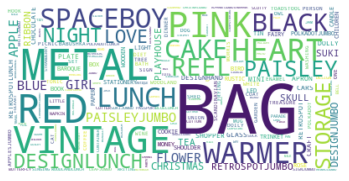

In [72]:
#Bag
text0 = get_text(data[data['cluster']==0])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text0)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [55]:
text1 = get_text(data[data['cluster']==1])

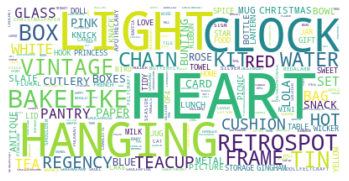

In [61]:
#general house supplies
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text1)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

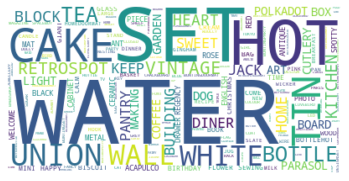

In [60]:
#tea time
text2 = get_text(data[data['cluster']==2])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text2)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

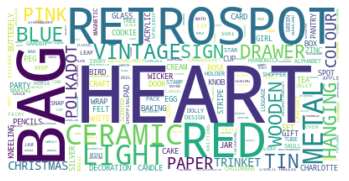

In [30]:
#Decorations
text3 = get_text(data[data['cluster']==3])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text3)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

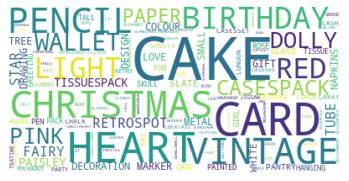

In [51]:
#celebratory items
text4 = get_text(data[data['cluster']==4])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text4)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

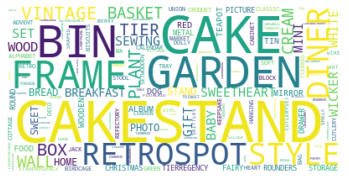

In [52]:
#Home, Garden & Tools
text5 = get_text(data[data['cluster']==5])
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text5)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#536370, 536381, 536390, 536367, 536522, 536532, 536559, 546189, 546190, 554817

# Recommendation Function

In [5]:
y = pd.get_dummies(data.cluster, prefix='Cluster')
y.rename(columns={"Cluster_0.0":"bags","Cluster_1.0":"house_supplies","Cluster_2.0":"tea_time","Cluster_3.0":"decoration","Cluster_4.0":"celebratory_items","Cluster_5.0":"home_garden_tools"},inplace=True)
y['invoice']=data.InvoiceNo

In [6]:
y_occur = (y.groupby(by=y.invoice).sum()/y.groupby(by=y.invoice).sum()).fillna(0)

In [7]:
def online_retailer_recommendation(purchase_list):
    #celebratory co-occurance
    CI_co1 = len(y_occur[(y_occur['celebratory_items']!=0)&(y_occur['bags']!=0)])
    CI_co2 = len(y_occur[(y_occur['celebratory_items']!=0)&(y_occur['house_supplies']!=0)])
    CI_co3 = len(y_occur[(y_occur['celebratory_items']!=0)&(y_occur['tea_time']!=0)])
    CI_co4 = len(y_occur[(y_occur['celebratory_items']!=0)&(y_occur['decoration']!=0)])
    CI_co = [CI_co1,CI_co2,CI_co3,CI_co4]
    #home,garden,tools co-occurance
    HGT_co1 = len(y_occur[(y_occur['home_garden_tools']!=0)&(y_occur['bags']!=0)])
    HGT_co2 = len(y_occur[(y_occur['home_garden_tools']!=0)&(y_occur['house_supplies']!=0)])
    HGT_co3 = len(y_occur[(y_occur['home_garden_tools']!=0)&(y_occur['tea_time']!=0)])
    HGT_co4 = len(y_occur[(y_occur['home_garden_tools']!=0)&(y_occur['decoration']!=0)])
    HGT_co = [HGT_co1,HGT_co2,HGT_co3,HGT_co4]
    #S_ab scores
    CI_Sab = [j/(math.sqrt(i *y_occur.sum()[4])) for i,j in zip(y_occur.sum()[0:4].tolist(),CI_co)]
    HGT_Sab = [j/(math.sqrt(i *y_occur.sum()[5])) for i,j in zip(y_occur.sum()[0:4].tolist(),HGT_co)]
    
    CI_result = [i*j for i,j in zip(purchase_list,CI_Sab)]
    HGT_result = [i*j for i,j in zip(purchase_list,HGT_Sab)]
    if max(CI_result)>max(HGT_result):
        return "recommend celebratory items"
    elif max(CI_result)<max(HGT_result):
        return "recommend home, garden & tools"
    else:
        return "please try again"

In [10]:
online_retailer_recommendation([1,0,0,1])

'recommend celebratory items'

In [14]:
y_occur.head()

,bags,house_supplies,tea_time,decoration,celebratory_items,home_garden_tools
invoice,,,,,,
536365,0.0,1.0,1.0,0.0,0.0,0.0
536366,1.0,0.0,0.0,1.0,0.0,0.0
536367,1.0,1.0,1.0,1.0,0.0,1.0
536368,0.0,0.0,1.0,0.0,0.0,0.0
536369,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
y_occur.iloc[0][0:4].astype(int).tolist()

[0, 1, 1, 0]

In [40]:
y_new = y_occur[(y_occur.celebratory_items != 0.0) | (y_occur.home_garden_tools !=0.0)]
#y_new = y_new[(y_new.celebratory_items != 1.0) |(y_new.home_garden_tools != 1.0)]   

In [30]:
y_new.head()

,bags,house_supplies,tea_time,decoration,celebratory_items,home_garden_tools
invoice,,,,,,
536367,1.0,1.0,1.0,1.0,0.0,1.0
536374,0.0,0.0,0.0,0.0,0.0,1.0
536378,1.0,1.0,0.0,1.0,1.0,0.0
536382,1.0,1.0,1.0,1.0,0.0,1.0
536385,1.0,0.0,1.0,1.0,0.0,1.0


In [41]:
rec_celeb = []
for i in range(len(y_new)):
    if online_retailer_recommendation(y_new.iloc[i][0:4].astype(int).tolist())=='recommend celebratory items':
        rec_celeb.append(1)
    else:
        rec_celeb.append(0)

In [37]:
y_new.loc[:,'celebratory_items'].astype(int).tolist()

[0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,


In [38]:
from sklearn.metrics import accuracy_score

In [39]:
accuracy_score(y_new.loc[:,'celebratory_items'].astype(int).tolist(),rec_celeb)

0.6904407662265204

In [42]:
accuracy_score(y_new.loc[:,'celebratory_items'].astype(int).tolist(),rec_celeb)

0.8098044771890054